In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import os
from scipy import sparse

# 1. Get the sparse matrix for Train data 

In [5]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("There is no file... Get the file and try again..")

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:03.957262


### Sparsity

In [6]:
u,m = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

In [7]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(u*m))) * 100) )

Sparsity Of matrix : 99.8292709259195 % 


# 2. Get the sparse matrix for Test data

In [8]:

start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("There is no file... Get the file and try again..")

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:01.037832


### Sparsity

In [9]:
u,m = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

In [10]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(u*m))) * 100) )

Sparsity Of matrix : 99.95731772988694 % 


# Sampling Train and Test data 

In [11]:
import os
import random

## Train

In [12]:
start = datetime.now()
if os.path.isfile('sample/medium/sample_train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz('sample/medium/sample_train_sparse_matrix.npz')
    print("DONE..")
else: 
    train_row_ind, train_col_ind = train_sparse_matrix.nonzero()
    train_row_ind = np.unique(train_row_ind)
    train_col_ind = np.unique(train_col_ind)

    print("In big matrix, (users, movies) : ({} {})".format(len(train_row_ind), len(train_col_ind)))

    np.random.seed(15)
    sample_train_movies = np.random.choice(train_col_ind, 2000, replace=False)
    sample_train_users = np.random.choice(train_row_ind, 20000, replace=False)

    sample_train_sparse_matrix = train_sparse_matrix[sample_train_users, :][:,sample_train_movies]
    
    print('In sampled matrix, (users, movies) : ({}, {}) '.format(len(sample_train_users),
                                                                  len(sample_train_movies)))
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/medium/sample_train_sparse_matrix.npz", sample_train_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.025511


In [13]:
sample_train_sparse_matrix.count_nonzero()

473343

## Test

In [14]:
import os
from scipy import sparse

start = datetime.now()
if os.path.isfile('sample/medium/sample_test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz('sample/medium/sample_test_sparse_matrix.npz')
    print("DONE..")
else: 
    test_row_ind, test_col_ind = test_sparse_matrix.nonzero()
    test_row_ind = np.unique(test_row_ind)
    test_col_ind = np.unique(test_col_ind)

    print("In big matrix (users, movies) : ({} {})".format(len(test_row_ind), len(test_col_ind)))

    np.random.seed(15)
    sample_test_movies = np.random.choice(test_col_ind, 3500, replace=False)
    sample_test_users = np.random.choice(test_row_ind, 10000, replace=False)

    sample_test_sparse_matrix = test_sparse_matrix[sample_test_users, :][:,sample_test_movies]
    
    print('In sampled matrix, (users, movies) : ({}, {}) '.format(len(sample_test_users),
                                                                  len(sample_test_movies)))
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/medium/sample_test_sparse_matrix.npz", sample_test_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.009030


In [15]:
sample_test_sparse_matrix.count_nonzero()

111758

# Computing Average Ratings (from Train data)

In [16]:
averages = dict()

In [17]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [18]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
averages['global'] = global_average
averages

{'global': 3.613916335511458}

### User averages

In [19]:
averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',averages['user'][10])


Average rating of user 10 : 3.6136363636363638


### Movie Averages

In [20]:
averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',averages['movie'][15])


 AVerage rating of movie 15 : 2.8


# Preparing Train and Test data for XGBoost

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 473343



### Preparing Train data 

In [23]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [26]:
start = datetime.now()
if os.path.isfile('sample/medium/reg_train.csv'):
    print("It is already in the disk. you don't have to prepare it again")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/medium/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # append user and movie
            row.append(user)
            row.append(movie)
            
            row.append(averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(averages['user'][user])
            # Avg_movie rating
            row.append(averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%50000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))    
print(datetime.now() - start)

preparing 473343 tuples for the dataset..

Done for 50000 rows----- 1:01:35.887983
Done for 100000 rows----- 2:03:56.974299
Done for 150000 rows----- 3:06:28.303297
Done for 200000 rows----- 4:09:03.574538
Done for 250000 rows----- 5:11:29.039651
Done for 300000 rows----- 6:15:06.767451
Done for 350000 rows----- 7:17:43.458965
Done for 400000 rows----- 8:20:12.038570
Done for 450000 rows----- 9:22:22.233366
9:51:35.236940


- __Reading from the file to make a Train_dataframe__

In [27]:
reg_train = pd.read_csv('sample/medium/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                         'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                        'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,536,0,3.613916,2.0,3.0,3.0,2.0,1.0,2.0,3.0,3.0,3.0,2.0,2.323529,2.166667,2
1,4809,0,3.613916,3.0,2.0,1.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,3.898305,2.166667,2
2,5886,0,3.613916,2.0,2.0,1.0,3.0,2.0,3.0,3.0,5.0,4.0,3.0,3.691358,2.166667,3
3,11013,0,3.613916,2.0,1.0,3.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.733333,2.166667,2
4,13954,0,3.613916,2.0,2.0,3.0,3.0,2.0,4.0,4.0,5.0,3.0,2.0,3.806452,2.166667,1


-----------------------
--

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------
--

- ### Preparing Test data

In [28]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [29]:
averages['global']

3.613916335511458

In [35]:
start = datetime.now()
cold_start_count = 0
if os.path.isfile('sample/medium/reg_test.csv'):
    print("It is already in the disk. you don't have to prepare it again")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/medium/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings, end="--")

            except KeyError:
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                cold_start_count = cold_start_count + 1
                top_sim_users_ratings.extend([averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_test_sparse_matrix[:,movie].T, sample_test_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except KeyError:
                cold_start_count = cold_start_count + 1
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
           
            row.append(user)
            row.append(movie)
            
            row.append(averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(averages['user'][user])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(averages['movie'][movie])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
print("",datetime.now() - start)

preparing 111758 tuples for the dataset..

Done for 10000 rows----- 0:02:37.092207
Done for 20000 rows----- 0:05:17.648127
Done for 30000 rows----- 0:07:56.476617
Done for 40000 rows----- 0:10:37.445904
Done for 50000 rows----- 0:13:21.438682
Done for 60000 rows----- 0:16:04.527684
Done for 70000 rows----- 0:18:43.946310
Done for 80000 rows----- 0:21:25.522198
Done for 90000 rows----- 0:24:02.879595
Done for 100000 rows----- 0:26:36.692239
Done for 110000 rows----- 0:29:11.422422
 0:29:39.353572


#### Percentage if Cold Start Cases handled

In [36]:
print("Cold Start Cases : {}%".format((cold_start_count/len(sample_test_ratings)) * 100 ))

Cold Start Cases : 48.239052237871114%


 - #### Reading from the file to make a Test_dataframe 

In [37]:
reg_test_df = pd.read_csv('sample/medium/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,8,0,3.613916,3.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,3.000000,2.000000,4.500000,2.166667,3
1,71,0,3.613916,3.0,4.0,4.0,1.0,3.0,4.0,5.0,5.0,3.642857,3.642857,3.642857,2.166667,4
2,123,0,3.613916,4.0,3.0,4.0,4.0,4.0,5.0,4.0,3.0,5.000000,5.000000,3.733333,2.166667,5
3,171,0,3.613916,4.0,4.0,5.0,5.0,4.0,2.0,3.0,5.0,4.000000,4.000000,3.666667,2.166667,3



-----------------------
--

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------
-- 

- - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - -  - .  

- ## Preparing Trainset and testset for Surprise based alorithms

### TrainSet

In [39]:
from surprise import Reader, Dataset

### Trainset 

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form trainset from a file, or from a Pandas  DataFram. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [40]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traidata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

### TestSet

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [41]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(8, 0, 3), (71, 0, 4), (123, 0, 5)]

# Some Global dictionary that stores rmse and mape for all the models....

- It stores the metrics in a dictionary of dictionaries

> __keys__ : model names(string)

> __value__: dict(__key__ : metric, __value__ : value )

In [42]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

# XGBoost Regressor

- ### Generic method to run an XGBoost model
     
 
 
     - given a properly initialized model, x_train, y_train, x_test, y_test

In [43]:
 # to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

- ## Generic function to run any Surprise based Algorithm 

In [44]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

# 1 First XGBoost with default parameters..  

In [45]:
import xgboost as xgb

Training the model..
Done. Time taken : 0:00:08.950745

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0578396579762788
MAPE :  31.56617664712411


<IPython.core.display.Javascript object>


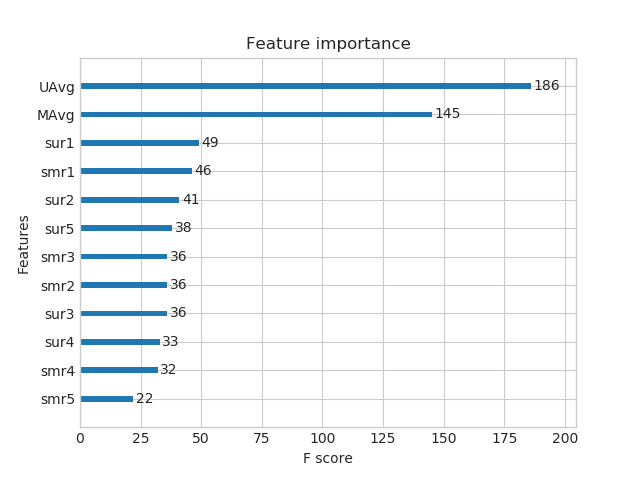

In [46]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

## 2. Baseline Model  ( with User and Item biases )

In [47]:
from surprise import BaselineOnly

- #### Predicted_rating : ( baseline prediction ) 

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 

 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $

-
- $\pmb \mu $ : Average of all trainings in TRAINSET
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

- ####  Optimization function ( Least Squares Problem ) 

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [48]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl = BaselineOnly(bsl_options=bsl_options)

# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:03.769053 

Evaluating the model with train data..
time taken : 0:00:04.662962
---------------
Train Data
---------------
RMSE : 0.9286840948358751

MAPE : 28.835593386690604

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.146453
---------------
Test Data
---------------
RMSE : 1.1174416718731566

MAPE : 34.216282444283095

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.579060


# 2. KNN with Baseline_model 

In [49]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 

- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating


- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  


- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
        - Computation of the correlation coefficient is based only on the common user support.
        - similarities based on a greater user support are more reliable ie., Users who has more number of common movie ratings are considered as more similar than users who has few no of movies  in common which are rated.
        - \begin{align}\begin{aligned}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{aligned}\end{align}
            - $\pmb{|I_{uv}|}$ - No of common movies between users(u and v)
            - __shrinkage__ - kind of hyperparameter. The defalut value suggested is ___100___
                - __0__ : There is no shrinkage at all ( It is normal pearson correlation coefficient ) 
            - $ \pmb {\hat \rho_uv}$ - Pearson-baseline Correlation Coefficient ( between users )
                - \begin{align} \text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
    \sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} -
    b_{vi})} {\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2}
    \cdot \sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}} \end{align}
 

 ------------ or 
 --

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

> We can do both and blend them ( see if we can better results when combined ) 

## 2.1 KNN with User User similarities 

In [50]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:03:38.724141 

Evaluating the model with train data..
time taken : 0:12:52.491443
---------------
Train Data
---------------
RMSE : 0.40764647891262024

MAPE : 11.363320055752846

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:14.845228
---------------
Test Data
---------------
RMSE : 1.2253430269623236

MAPE : 35.68951210657449

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:16:46.061786


## 2.2 KNN with Item Item similarities 

In [51]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:06.480378 

Evaluating the model with train data..
time taken : 0:00:52.334733
---------------
Train Data
---------------
RMSE : 0.4492346707665392

MAPE : 12.33760492858047

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:03.885333
---------------
Test Data
---------------
RMSE : 1.2386453277127252

MAPE : 36.22814809874049

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:02.700935


# 3. Matrix Factorization Techniques

## 3.1 SVD -  MF algorithm with user item interactions 

In [52]:
from surprise import SVD

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


 - A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [53]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:30.447906 

Evaluating the model with train data..
time taken : 0:00:05.263236
---------------
Train Data
---------------
RMSE : 0.6688856498432819

MAPE : 19.894941193530535

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.233937
---------------
Test Data
---------------
RMSE : 1.1628152107017902

MAPE : 34.71011522713972

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:36.945909


 ### 3.2 SVD -  with Implicit feedback of Items(movies)

In [54]:
from surprise import SVDpp

 ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__ 


   
- $ \Large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + y_j^2\right) $ 

In [55]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:14:39.822715 

Evaluating the model with train data..
time taken : 0:00:42.899421
---------------
Train Data
---------------
RMSE : 0.6481320180862212

MAPE : 18.57345441996823

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:03.793209
---------------
Test Data
---------------
RMSE : 1.175868077099885

MAPE : 34.77380478686918

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:15:26.515938


# 4. XGBoost with just the model predictions

In [57]:
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,536,0,3.613916,2.0,3.0,3.0,2.0,1.0,2.0,3.0,3.0,3.0,2.0,2.323529,2.166667,2
1,4809,0,3.613916,3.0,2.0,1.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,3.898305,2.166667,2


In [59]:
# adding the model predictions to reg_train and reg_test_df dataframes...

# Updating the train data.. 
for model in models_evaluation_train.keys():
    reg_train[model] = models_evaluation_train[model]['predictions']

# Updating test data...
for model in models_evaluation_test.keys():
    reg_test_df[model] = models_evaluation_test[model]['predictions']

# after updating train data
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr5,UAvg,MAvg,rating,first_algo,bsl_algo,knn_bsl_u,knn_bsl_m,svd,svdpp
0,536,0,3.613916,2.0,3.0,3.0,2.0,1.0,2.0,3.0,...,2.0,2.323529,2.166667,2,1.604739,2.546102,1.995398,2.008414,1.775302,1.649806
1,4809,0,3.613916,3.0,2.0,1.0,3.0,2.0,3.0,4.0,...,4.0,3.898305,2.166667,2,2.641485,2.519786,2.999880,2.926779,2.368979,2.473108


Training the model..
Done. Time taken : 0:00:14.900877

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0906004003347776
MAPE :  34.231121518249005


<IPython.core.display.Javascript object>


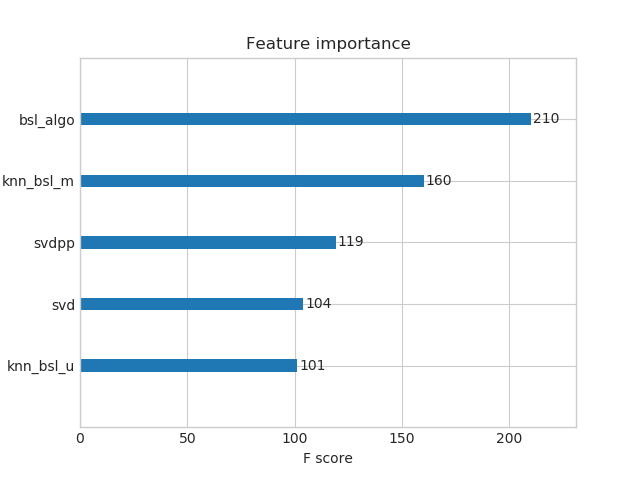

In [61]:
# prepare train data
x_train = reg_train[['bsl_algo','knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['bsl_algo','knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

# 5. XGBoost with every feature (xgb_final)

Training the model..
Done. Time taken : 0:00:17.960124

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0695288600547508
MAPE :  31.725114789467305


<IPython.core.display.Javascript object>


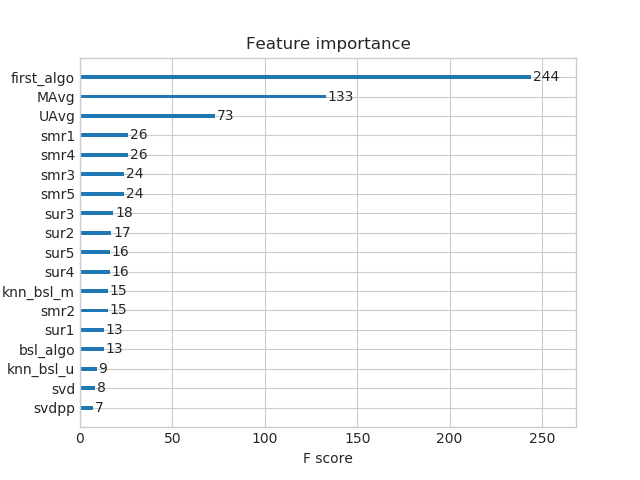

In [66]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

 - __Saving our TEST_RESULTS into a dataframe so that you don't have to run it again..__ 

In [67]:
pd.DataFrame(models_evaluation_test).to_csv('sample/medium/medium_sample_results.csv')

- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 
- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 
- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 

In [68]:
models = pd.read_csv('sample/medium/medium_sample_results.csv', index_col=0)

In [69]:
models.loc['rmse'].sort_values()

first_algo        1.0578396579762788
xgb_final         1.0695288600547508
xgb_all_models    1.0906004003347776
bsl_algo          1.1174416718731566
svd               1.1628152107017902
svdpp              1.175868077099885
knn_bsl_u         1.2253430269623236
knn_bsl_m         1.2386453277127252
Name: rmse, dtype: object

 - ### Observations: 
 

* Again, It is proved that __blending of different models__ with XGBoost __can decrease rmse__.

    - >  XGBoost with features as predictions from Neighbourhood and Matrix Factorization model and with previous features(averages, similar_users_ratings and similar_movies_ratings): RMSE( __1.0695__ )

* __Interesting__ :
    - > For this medium sample, performance of XGBoost is BETTER __without the predictions__ from previous models.
    - > RMSE(__1.0578__)
 

------------------------------------
- Both are almost same. It might change when tested with complete data (100 Million ratings). But It is sure that XGBoost can increase performance with/without blending..

-----------------